<a href="https://colab.research.google.com/github/Mahdi-cs-mlops/NeuroResilience-DRL/blob/main/NeuroResilience_DRL_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. نصب کتابخانه های مورد نیاز (این خط را در کولب اجرا کنید)
!pip install gymnasium stable-baselines3 networkx matplotlib shimmy

محیط تایید شد! شروع آموزش...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



در حال رسم نمودار یادگیری...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Figure size 1000x500 with 0 Axes>

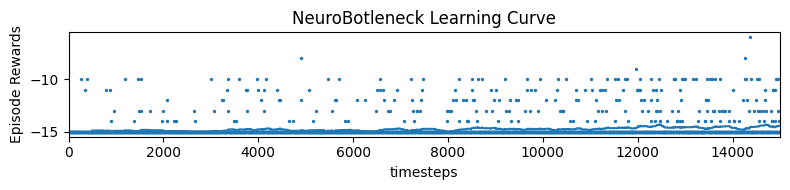


تست عملکرد عامل پس از آموزش:
گام 1: حذف یال 433 -> پاداش: -3.0
گام 2: حذف یال 271 -> پاداش: -3.0
گام 3: حذف یال 351 -> پاداش: -3.0
گام 4: حذف یال 70 -> پاداش: -2.0
گام 5: حذف یال 239 -> پاداش: -2.0
پاداش نهایی: -13.0


In [2]:
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor # برای ذخیره لاگ‌ها جهت رسم نمودار
import os

# --- بخش اول: اصلاح محیط گراف ---
class GraphInterdictionEnv(gym.Env):
    def __init__(self, num_nodes=20, num_edges_to_remove=3):
        super(GraphInterdictionEnv, self).__init__()
        self.num_nodes = num_nodes
        self.budget = num_edges_to_remove

        # گراف پایه
        self.base_graph = nx.barabasi_albert_graph(num_nodes, 3)
        for u, v in self.base_graph.edges():
            self.base_graph[u][v]['capacity'] = 1.0

        self.source = 0
        self.target = num_nodes - 1

        self.max_edges = self.num_nodes * (self.num_nodes - 1) // 2
        self.action_space = spaces.Discrete(self.max_edges)

        # اصلاح مهم: تعریف دقیق نوع داده
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_graph = self.base_graph.copy()
        self.steps_taken = 0
        self.edge_list = list(self.current_graph.edges())

        # اصلاح خطای اصلی: تبدیل صریح به float32
        obs = nx.to_numpy_array(self.current_graph, dtype=np.float32)
        return obs, {}

    def step(self, action):
        if action < len(self.edge_list):
            edge_to_remove = self.edge_list[action]
            if self.current_graph.has_edge(*edge_to_remove):
                self.current_graph.remove_edge(*edge_to_remove)

        try:
            flow_value = nx.maximum_flow_value(self.current_graph, self.source, self.target)
        except:
            flow_value = 0

        reward = -flow_value

        self.steps_taken += 1
        terminated = self.steps_taken >= self.budget
        truncated = False

        # اصلاح خطای اصلی: تبدیل صریح به float32
        obs = nx.to_numpy_array(self.current_graph, dtype=np.float32)

        return obs, reward, terminated, truncated, {}

# --- بخش دوم: آموزش و ذخیره لاگ‌ها ---

# ساخت پوشه برای لاگ‌ها
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# ساخت محیط و اتصال مانیتور (برای رسم نمودار)
env = GraphInterdictionEnv(num_nodes=30, num_edges_to_remove=5)
env = Monitor(env, log_dir) # این خط حیاتی است برای نمودار

# چک کردن محیط (الان باید پاس شود)
check_env(env)
print("محیط تایید شد! شروع آموزش...")

# تعریف مدل
model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003)

# آموزش (تعداد گام‌ها را کم کردم تا سریع تست بگیرید، برای مقاله باید بیشتر باشد)
model.learn(total_timesteps=15000)

# --- بخش سوم: رسم نمودار حرفه‌ای ---
from stable_baselines3.common import results_plotter

print("\nدر حال رسم نمودار یادگیری...")
plt.figure(figsize=(10, 5))
results_plotter.plot_results([log_dir], 15000, results_plotter.X_TIMESTEPS, "NeuroBotleneck Learning Curve")
plt.show()

# --- بخش چهارم: تست نهایی ---
print("\nتست عملکرد عامل پس از آموزش:")
obs, _ = env.reset()
total_reward = 0
for i in range(5):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    print(f"گام {i+1}: حذف یال {action} -> پاداش: {reward}")

print(f"پاداش نهایی: {total_reward}")

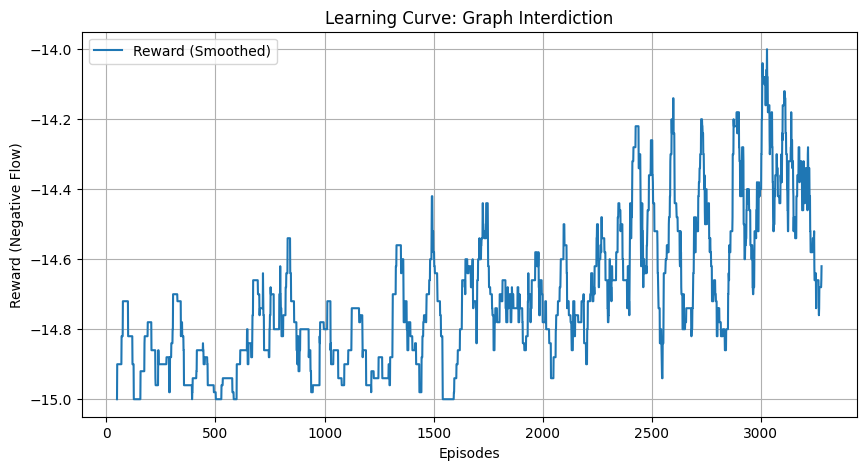

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# خواندن فایل لاگ که توسط Monitor ساخته شده
data = pd.read_csv("/tmp/gym/monitor.csv", skiprows=1)

# رسم نمودار میانگین متحرک (برای نرم کردن نوسانات)
plt.figure(figsize=(10, 5))
plt.plot(data['r'].rolling(window=50).mean(), label="Reward (Smoothed)")
plt.title("Learning Curve: Graph Interdiction")
plt.xlabel("Episodes")
plt.ylabel("Reward (Negative Flow)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# 1. نصب کتابخانه مخصوص ماسک (sb3-contrib)
!pip install gymnasium stable-baselines3 sb3-contrib networkx shimmy matplotlib

import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib.common.wrappers import ActionMasker
import os

# --- تعریف محیط با قابلیت ماسک‌گذاری ---
class GraphInterdictionEnv(gym.Env):
    def __init__(self, num_nodes=30, num_edges_to_remove=5):
        super(GraphInterdictionEnv, self).__init__()
        self.num_nodes = num_nodes
        self.budget = num_edges_to_remove

        # گراف پایه (Barabasi-Albert)
        self.base_graph = nx.barabasi_albert_graph(num_nodes, 3)
        for u, v in self.base_graph.edges():
            self.base_graph[u][v]['capacity'] = 1.0

        self.source = 0
        self.target = num_nodes - 1

        # فضای اکشن و مشاهده
        self.max_edges = self.num_nodes * (self.num_nodes - 1) // 2
        self.action_space = spaces.Discrete(len(self.base_graph.edges()))
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_nodes, num_nodes), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_graph = self.base_graph.copy()
        self.steps_taken = 0

        # لیست ثابت یال‌ها (نگاشت اکشن به یال)
        self.edge_list = list(self.base_graph.edges())

        # وضعیت حذف شدن یال‌ها (False یعنی هنوز هست، True یعنی حذف شده)
        self.removed_edges = np.zeros(len(self.edge_list), dtype=bool)

        return self._get_obs(), {}

    def _get_obs(self):
        return nx.to_numpy_array(self.current_graph, dtype=np.float32)

    # --- متد جدید: ماسک اکشن‌ها ---
    def action_masks(self):
        # این متد به مدل می‌گوید کدام اکشن‌ها مجاز هستند (True) و کدام غیرمجاز (False)
        # فقط یال‌هایی که هنوز حذف نشده‌اند (removed_edges == False) قابل انتخاب‌اند
        return ~self.removed_edges

    def step(self, action):
        # اینجا دیگر نیاز به چک کردن اعتبار اکشن نیست، چون ماسک تضمین می‌کند اکشن معتبر است
        edge_to_remove = self.edge_list[action]

        # حذف یال از گراف
        self.current_graph.remove_edge(*edge_to_remove)

        # علامت‌گذاری یال به عنوان حذف شده
        self.removed_edges[action] = True

        # محاسبه جریان (پاداش)
        try:
            flow_value = nx.maximum_flow_value(self.current_graph, self.source, self.target)
        except:
            flow_value = 0

        reward = -flow_value

        self.steps_taken += 1
        terminated = self.steps_taken >= self.budget
        truncated = False

        return self._get_obs(), reward, terminated, truncated, {}

# --- تابع کمکی برای رپر (Wrapper) ---
def mask_fn(env: gym.Env) -> np.ndarray:
    return env.action_masks()

# --- اجرا و آموزش ---

# 1. ساخت محیط
env = GraphInterdictionEnv(num_nodes=30, num_edges_to_remove=5)

# 2. رپ کردن محیط (اتصال تابع ماسک به محیط)
env = ActionMasker(env, mask_fn)

# 3. تعریف مدل (توجه: استفاده از MaskablePPO به جای PPO معمولی)
model = MaskablePPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)

print("شروع آموزش با Action Masking...")
model.learn(total_timesteps=10000)

# --- تست هوشمند ---
print("\n--- تست با ماسک ---")
obs, _ = env.reset()
total_reward = 0

# دریافت ماسک‌های اولیه
dones = False
while not dones:
    # دریافت ماسک اکشن‌های مجاز برای وضعیت فعلی
    action_masks = get_action_masks(env)

    # انتخاب اکشن هوشمند با لحاظ کردن ماسک
    action, _states = model.predict(obs, action_masks=action_masks)

    obs, reward, dones, _, _ = env.step(action)
    total_reward += reward

    # پیدا کردن یال حذف شده برای چاپ
    edge_idx = int(action)
    # دسترسی به محیط اصلی از داخل Wrapper
    real_env = env.unwrapped
    removed_edge = real_env.edge_list[edge_idx]

    print(f"یال {removed_edge} حذف شد. پاداش لحظه‌ای: {reward}")

print(f"پاداش نهایی: {total_reward}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.2 MB/s eta 0:00:00
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
شروع آموزش با Action Masking...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    fps             | 259      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5           |
|    ep_rew_mean          | -14.5       |
| time/                   |             |
|    fps                  | 234         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01649